In [24]:
import joblib

import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [25]:
df = pd.read_csv('./census_cleaned.csv')

In [26]:
df

,age,workclass,marital-status,occupation,race,sex,hours-per-week,salary
0,39,State-gov,Never-married,Adm-clerical,White,Male,40,<=50K
1,50,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,White,Male,13,<=50K
2,38,Private,Divorced,Handlers-cleaners,White,Male,40,<=50K
3,53,Private,Married-civ-spouse,Handlers-cleaners,Black,Male,40,<=50K
4,28,Private,Married-civ-spouse,Prof-specialty,Black,Female,40,<=50K
...,...,...,...,...,...,...,...,...
20307,32,Private,Never-married,Tech-support,Asian-Pac-Islander,Male,11,<=50K
20308,22,Private,Never-married,Protective-serv,White,Male,40,<=50K
20309,27,Private,Married-civ-spouse,Tech-support,White,Female,38,<=50K
20310,58,Private,Widowed,Adm-clerical,White,Female,40,<=50K


In [5]:
def get_age_group(age):
    if age < 18:
        return 'underage'
    elif (age >= 18) & (age < 60):
        return 'adult'
    else:
        return 'elder'

def get_salary_group(salary):
    if salary == '<=50K':
        return 1
    return 0


In [6]:
df['age'] = df['age'].apply(get_age_group)
df['salary'] = df['salary'].apply(get_salary_group)

In [7]:
def encoder_label(df, attribute):
    le = preprocessing.LabelEncoder()
    le.fit(list(set(df[attribute])))
    df[attribute] = le.transform(df[attribute])
    np.save(f'./encode_labels/{attribute}.npy', le.classes_)

In [8]:
encoder_label(df,'age')
encoder_label(df,'sex')
encoder_label(df,'race')
encoder_label(df,'occupation')
encoder_label(df,'workclass')
encoder_label(df,'marital-status')

In [9]:
df.to_csv('./census_eda.csv')

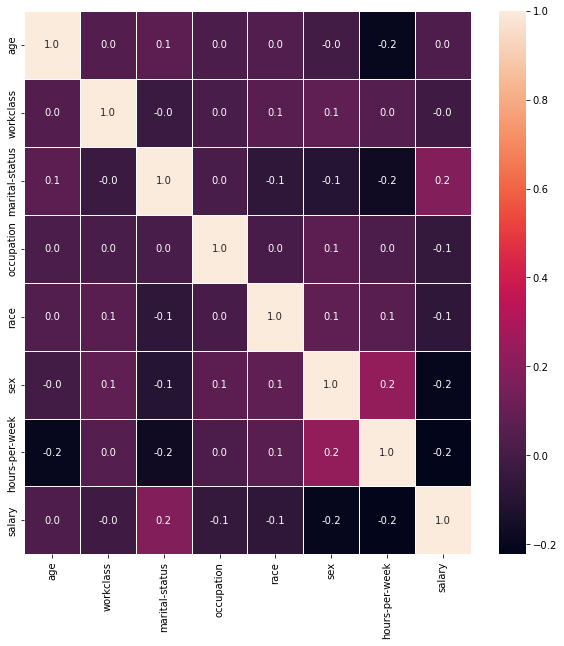

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize=(10, 10))
heatmap = sns.heatmap(df[['age','workclass','marital-status','occupation','relationship','race','sex',
                         'hours-per-week','salary']].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

figure = heatmap.get_figure()    
# figure.savefig('heatmap.png', dpi=400)

# Below are model training script

In [11]:
from sklearn.model_selection import KFold

In [12]:
folds = 5

In [13]:
kf = KFold(n_splits=folds, random_state=42, shuffle=True)

In [14]:
df = df[['age','workclass','marital-status','occupation','race','sex', 'hours-per-week','salary']]

In [15]:
y = df['salary'].values
X = df.drop('salary', axis=1).values

In [16]:
from sklearn.model_selection import train_test_split
X, X_testset, y, y_testset = train_test_split(X, y, test_size = 0.2, shuffle=True)

In [24]:
model_arr = []
roc_arr = []

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = lgb.LGBMClassifier(objective='binary',
                             random_state=42,
                             metric='binary_logloss',
                             scale_pos_weight=0.34)
    

    
    clf.fit(X_train, y_train)
    roc_ = roc_auc_score(y_test, clf.predict(X_test))
    model_arr.append(clf)
    roc_arr.append(roc_)
    print('--------------------------------------------------------------')
    print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
    print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))
    print('ROC', roc_)
    
    
max_index = np.argmax(np.array(roc_arr))
best_clf = model_arr[max_index]


# save model
joblib.dump(best_clf, 'best_clf.pkl')
# load model
# gbm_pickle = joblib.load('clf_opt.pkl')

--------------------------------------------------------------
Training set score: 0.7867
Test set score: 0.7609
ROC 0.76513915946023
--------------------------------------------------------------
Training set score: 0.7773
Test set score: 0.7602
ROC 0.7746650678523495
--------------------------------------------------------------
Training set score: 0.7781
Test set score: 0.7645
ROC 0.7852856503411831
--------------------------------------------------------------
Training set score: 0.7787
Test set score: 0.7637
ROC 0.7796462191260715
--------------------------------------------------------------
Training set score: 0.7829
Test set score: 0.7597
ROC 0.7701280945378118


['best_clf.pkl']

In [ ]:
y_pred=clf.predict(X_testset)

In [ ]:
# view accuracy

accuracy=accuracy_score(y_pred, y_testset)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_testset, y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_testset, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
from sklearn.metrics import roc_auc_score
roc_ = roc_auc_score(y_testset, y_pred)
print(roc_)

In [12]:
np.arange(1, 10).reshape(3,3)[:,-1]

array([3, 6, 9])

In [13]:
np.arange(1, 10).reshape(3,3)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [14]:


from sklearn import preprocessing

In [28]:
def label_encoder(df, attribute, training):
    le = preprocessing.LabelEncoder()
    
    if training:
        le.fit(list(set(df[attribute])))        
#         save_encoder_classes(f'./data/label_encoders/{attribute}.npy', attribute, le)
    else:
        le.classes_ = np.load(f'./label_encoders/{attribute}.npy')
    df[attribute] = le.transform(df[attribute])

In [29]:
label_encoder(df, 'race', False)

In [30]:
df

,age,workclass,marital-status,occupation,race,sex,hours-per-week,salary
0,39,State-gov,Never-married,Adm-clerical,4,Male,40,<=50K
1,50,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,4,Male,13,<=50K
2,38,Private,Divorced,Handlers-cleaners,4,Male,40,<=50K
3,53,Private,Married-civ-spouse,Handlers-cleaners,2,Male,40,<=50K
4,28,Private,Married-civ-spouse,Prof-specialty,2,Female,40,<=50K
...,...,...,...,...,...,...,...,...
20307,32,Private,Never-married,Tech-support,1,Male,11,<=50K
20308,22,Private,Never-married,Protective-serv,4,Male,40,<=50K
20309,27,Private,Married-civ-spouse,Tech-support,4,Female,38,<=50K
20310,58,Private,Widowed,Adm-clerical,4,Female,40,<=50K
